In [1]:
from aio_overpass import Client, Query
from aio_overpass.element import collect_elements

client = Client()

hamburg_query = Query(f"""
area["name:en"=Germany];
rel(area)[name=Hamburg][boundary=administrative];
out geom;
""")

await client.run_query(hamburg_query)

hamburg_rel, = collect_elements(hamburg_query)

# pick the large part
hamburg_poly = max(hamburg_rel.geometry.geoms, key=lambda g: g.area)

# simplify with shapely - not a geodesic operation
hamburg_poly_simple = hamburg_poly.simplify(0.025, preserve_topology=False)

# how many vertices left on this polygon?
len(hamburg_poly_simple.exterior.coords)

18

In [2]:
from aio_overpass.ql import poly_clause

clause = poly_clause(hamburg_poly_simple)

hamburg_park_query = Query(f"""
way{clause}[leisure=park];
out geom;
""")

await client.run_query(hamburg_park_query)

park_elements = collect_elements(hamburg_park_query)

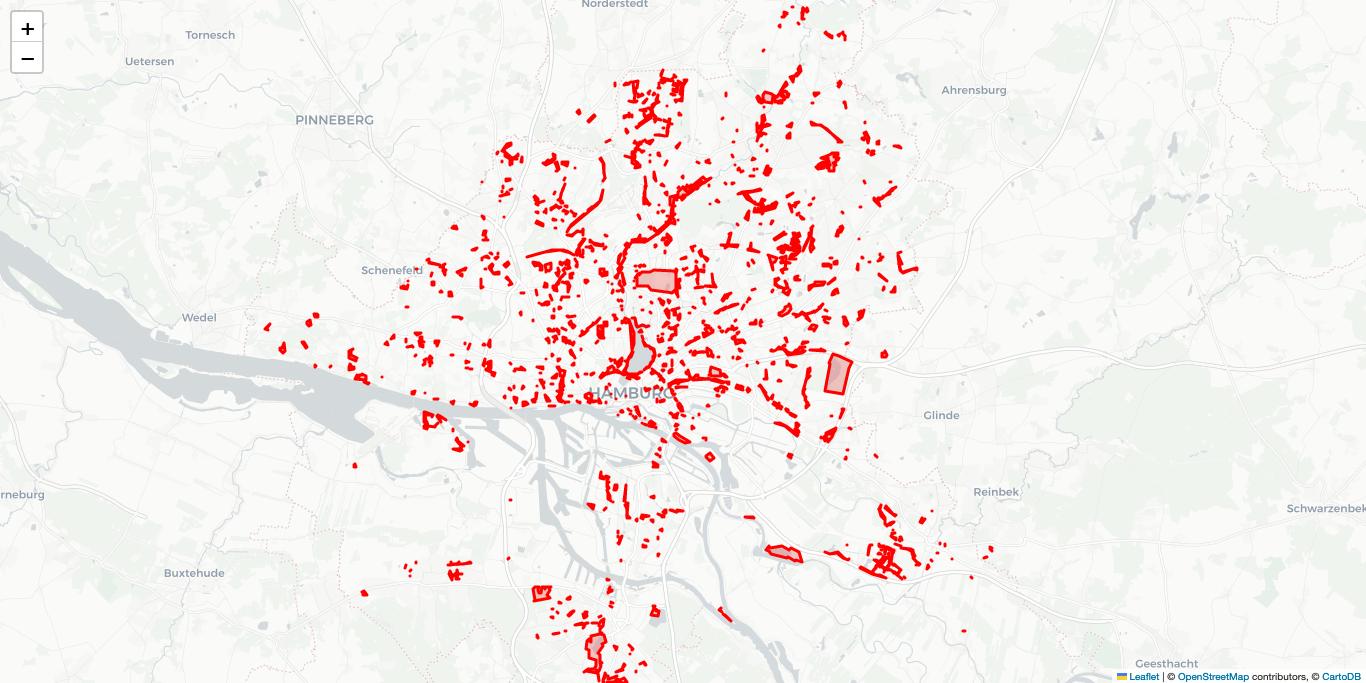

In [8]:
import folium
from folium.vector_layers import Polygon
import IPython.display
from shapely.geometry import GeometryCollection

interactive = False
zoom = 11

centroid = GeometryCollection([way.geometry for way in park_elements]).centroid

m = folium.Map(
    tiles="http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png",
    attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
    location=centroid.coords[0],
    zoom_start=zoom,
)

for way in park_elements:
    ext = way.geometry.exterior.coords
    holes = [i.coords for i in way.geometry.interiors]
    Polygon(
        locations=[ext] + holes,
        color="red", fill_color="red",
    ).add_to(m)

if interactive:
    IPython.display.display(IPython.display.HTML('<h1>Parks in the administrative area of Hamburg</h1>'))
    IPython.display.display(m)
else:
    image = IPython.display.Image(data=m._to_png(), format='png', embed=True)
    IPython.display.display(IPython.display.HTML('<h1>Parks in the administrative area of Hamburg</h1>'))
    IPython.display.display(image)